# COVID19 analisi

## Pacchetti utili

In [48]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## Recuperiamo i dati da github

In [49]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [50]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

## Logistic model

In [51]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)*a))

In [52]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[0.2,100,30000])
fit

(array([2.27508496e-01, 7.62009416e+01, 6.47102706e+04]),
 array([[ 2.11075334e-05, -1.83642106e-03, -1.44180962e+01],
        [-1.83642106e-03,  1.78260553e-01,  1.42729916e+03],
        [-1.44180962e+01,  1.42729916e+03,  1.15182391e+07]]))

In [53]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [54]:
a=fit[0][0]
b=fit[0][1]
c=fit[0][2]
print('a =', fit[0][0])
print('b =', fit[0][1])
print('c =', fit[0][2])

a = 0.22750849619168406
b = 76.2009416070293
c = 64710.270561045225


In [55]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
sol

130

## Exponential model

In [56]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [57]:
exp_fit = curve_fit(exponential_model,x,y,p0=[0.005,0.17,50])
print('a =', exp_fit[0][0])
print('b =', exp_fit[0][1])
print('c =', exp_fit[0][2])

a = 0.7107324795206795
b = 0.16849942955471556
c = 12.186346878071731


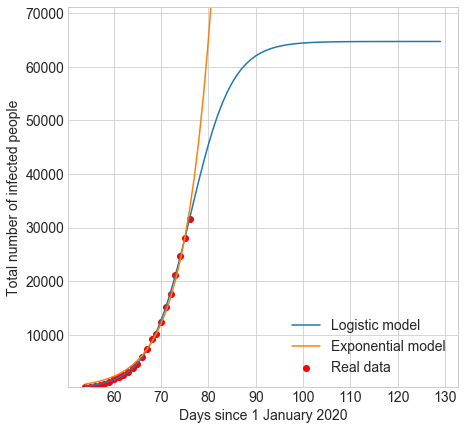

In [58]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.style.use('seaborn-whitegrid')
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

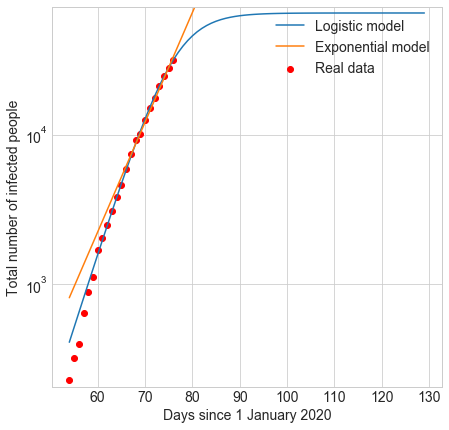

In [59]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.style.use('seaborn-whitegrid')
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.semilogy(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

# Predicted exponential curve
plt.semilogy(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [60]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1],exp_fit[0][2]) for i in x]
print('MSE logistic curve:    ',mean_squared_error(y,y_pred_logistic))
print('MSE exponential curve: ',mean_squared_error(y,y_pred_exp))

MSE logistic curve:     42420.04825989726
MSE exponential curve:  519896.30359085236


## Infected increases, ratio and difference

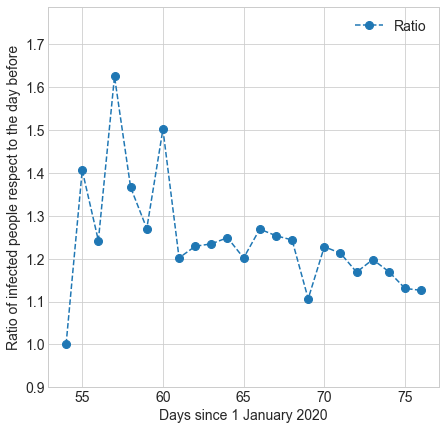

In [61]:
Y2=np.array(y)
Y1=np.array(y)
Y1=np.delete(Y1,-1)
Y1=np.insert(Y1,0,Y1[0])
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
# plt.scatter(x,Y2/Y1,label="Ratio",color="red")
plt.plot(x,Y2/Y1,"--o",markersize=8,label="Ratio")
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Ratio of infected people respect to the day before")
plt.ylim((min(Y2/Y1)*0.9,max(Y2/Y1)*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()

In [62]:
def logistic_model_derivative(x,a,b,c):
    return a*c*np.exp(-a*(x-b))/(1+np.exp(-(x-b)*a))**2

In [63]:
Y2=np.array(y)
Y1=np.array(y)
Y1=np.delete(Y1,-1)
Y1=np.insert(Y1,0,Y1[0])
Y3=Y2-Y1
X=np.array(x)
X=np.delete(X,15,axis=0)
Y3=np.delete(Y3,15,axis=0)

In [64]:
fit_derivative = curve_fit(logistic_model_derivative,X,Y3,p0=[0.2,70,64000])
print('a =', fit_derivative[0][0])
print('b =', fit_derivative[0][1])
print('c =', fit_derivative[0][2])
fit_derivative

a = 0.23967449354754183
b = 75.51179711054161
c = 58276.40019044714


(array([2.39674494e-01, 7.55117971e+01, 5.82764002e+04]),
 array([[ 2.11042222e-04, -7.29464947e-03, -6.08959437e+01],
        [-7.29464947e-03,  3.35488699e-01,  2.44531234e+03],
        [-6.08959437e+01,  2.44531234e+03,  2.01221956e+07]]))

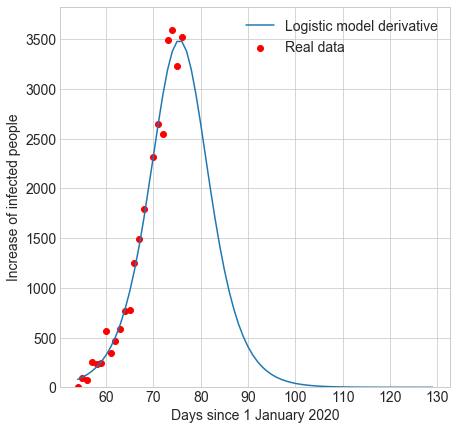

In [65]:
# plt.rcParams['figure.figsize'] = [7, 7]
# plt.rc('font', size=14)

# # Real data
# plt.plot(X,Y3,"--or",markersize=8,label="Difference")
# plt.legend()
# plt.xlabel("Days since 1 January 2020")
# plt.ylabel("Infected increase respecto to day 1")
# plt.ylim(min(Y3)*0.9,max(Y3)*1.1)
# plt.style.use('seaborn-whitegrid')
# plt.show()



pred_x = list(range(max(X),sol))

plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(X,Y3,label="Real data",color="red")

# Predicted logistic curve
plt.plot(list(X)+pred_x, [logistic_model_derivative(i,fit_derivative[0][0],fit_derivative[0][1],fit_derivative[0][2]) for i in list(X)+pred_x], label="Logistic model derivative" )

# Predicted exponential curve
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Increase of infected people")
plt.ylim((min(Y3)*0.9,max([logistic_model_derivative(i,fit_derivative[0][0],fit_derivative[0][1],fit_derivative[0][2]) for i in list(X)+pred_x])*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()

## Deaths analysis

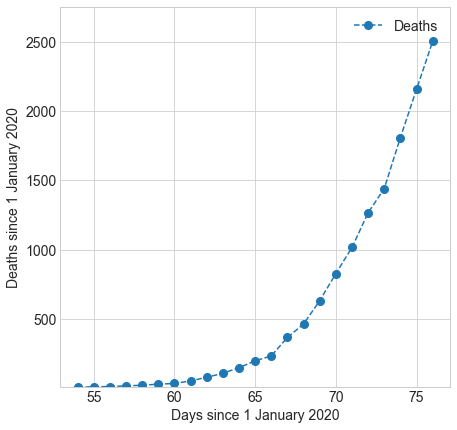

In [66]:
df = pd.read_csv(url)
df = df.loc[:,['data','deceduti']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

plt.plot(x,y,"--o",markersize=8,label="Deaths")
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Deaths since 1 January 2020")
plt.ylim((min(y)*0.9,max(y)*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()

In [67]:
fit = curve_fit(logistic_model,x,y,p0=[0.3,70,3000])
a=fit[0][0]
b=fit[0][1]
c=fit[0][2]
print('a =', a)
print('b =', b)
print('c =', c)

a = 0.2936225126780852
b = 75.35397405480771
c = 4542.825943884896


In [68]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
sol

104

In [69]:
exp_fit = curve_fit(exponential_model,x,y,p0=[3,0.28,50])
print('a =', exp_fit[0][0])
print('b =', exp_fit[0][1])
print('c =', exp_fit[0][2])

a = 6.177514722793462
b = 0.2073404915897801
c = 46.80206685994238


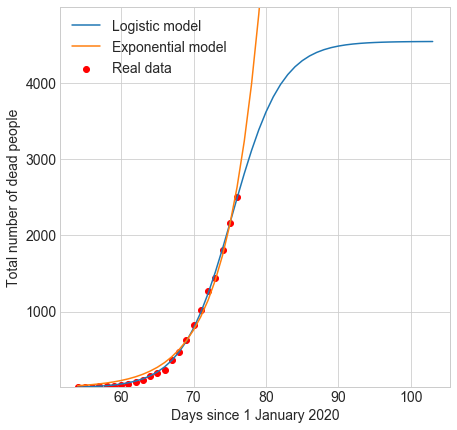

In [70]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x],label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of dead people")
plt.ylim((min(y)*0.9,c*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()

In [71]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1],exp_fit[0][2]) for i in x]
print('MSE logistic curve:    ',mean_squared_error(y,y_pred_logistic))
print('MSE exponential curve: ',mean_squared_error(y,y_pred_exp))

MSE logistic curve:     573.9095440142231
MSE exponential curve:  4160.193564565952


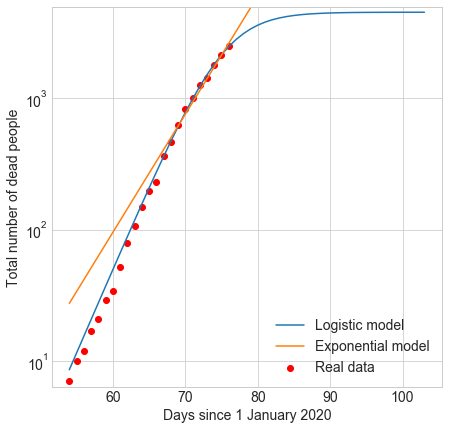

In [72]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.semilogy(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

# Predicted exponential curve
plt.semilogy(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x],label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of dead people")
plt.ylim((min(y)*0.9,c*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()

In [73]:
Y2=np.array(y)
Y1=np.array(y)
Y1=np.delete(Y1,-1)
Y1=np.insert(Y1,0,Y1[0])
Y3=Y2-Y1
X=np.array(x)

In [74]:
fit_derivative = curve_fit(logistic_model_derivative,X,Y3,p0=[0.2,70,64000])
print('a =', fit_derivative[0][0])
print('b =', fit_derivative[0][1])
print('c =', fit_derivative[0][2])
fit_derivative

a = 0.25958733851281957
b = 77.24127364012774
c = 5628.996489776523


(array([2.59587339e-01, 7.72412736e+01, 5.62899649e+03]),
 array([[ 1.64812954e-03, -6.73261665e-02, -5.73022704e+01],
        [-6.73261665e-02,  3.26643641e+00,  2.66592135e+03],
        [-5.73022704e+01,  2.66592135e+03,  2.24935277e+06]]))

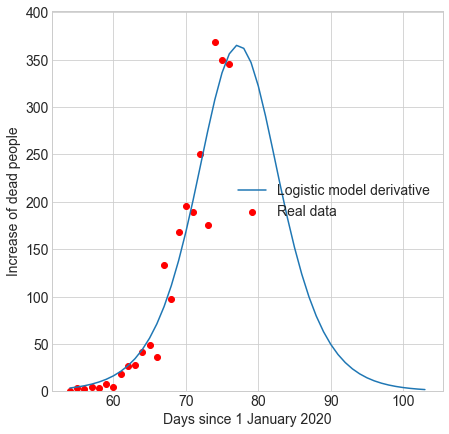

In [75]:
pred_x = list(range(max(X),sol))

plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(X,Y3,label="Real data",color="red")

# Predicted logistic curve
plt.plot(list(X)+pred_x, [logistic_model_derivative(i,fit_derivative[0][0],fit_derivative[0][1],fit_derivative[0][2]) for i in list(X)+pred_x], label="Logistic model derivative" )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Increase of dead people")
plt.ylim((min(Y3)*0.9,max([logistic_model_derivative(i,fit_derivative[0][0],fit_derivative[0][1],fit_derivative[0][2]) for i in list(X)+pred_x])*1.1))
plt.style.use('seaborn-whitegrid')
plt.show()